In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, LeakyReLU, ReLU, LayerNormalization, GaussianNoise
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D
from keras import initializers
from math import ceil
import time
from tensorflow_addons.layers import SpectralNormalization

In [2]:
#Updated Versions
#Spectral Normalization Model
def build_cifar10_discriminator(image_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #16 output filters, so number of channels jumps from 1 to 16
    #kernel_size = 5 means we use a 5x5 convolution window
    #strides defaults to (1,1) when unspecified, "same" padding means we'll preserve the image size
    model.add(Conv2D(16, kernel_size=5, strides=2, padding="same", input_shape=(32, 32, 3), 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))) #40
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(32, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    
    #Second layer
    model.add(SpectralNormalization(Conv2D(64, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(128, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))

    #Flatten for Final Output Layer
    model.add(Flatten())

    #Output layer
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Activation("sigmoid"))
    
    #Final Output
    print("\nDiscriminator")
    model.summary()
    return model




#Spectral Normalization Model
def build_cifar10_generator(z_dim=100):
    
    model = Sequential()
    
    #First Layer (4x4)
    model.add(Dense(4*4*128, input_dim=z_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Reshape((4,4,128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 8x8
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
          use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    # output layer
    model.add(Activation('tanh'))

    print("\nGenerator")
    model.summary()
    return model




#Build and Compile Networks
#Variables
#Loss Functions:  Don't seem to matter for performance, any choice will work
#Learning rates:  Trying higher learning rate for Discriminator;  
#Discriminator is easier to succeed, gives generator a better chance at competition, prevents mode collapse
lr_d=2e-4
lr_g=1e-4
z_dim=100
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
image_shape = X_train[0].shape

D = build_cifar10_discriminator(image_shape)
G = build_cifar10_generator(z_dim)

D.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
D.trainable = False

z = Input(shape=(z_dim, ))
D_of_G = Model(inputs=z, outputs=D(G(z)))
D_of_G.compile(Adam(learning_rate=lr_g, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])


Discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 spectral_normalization (Spe  (None, 8, 8, 32)         12864     
 ctralNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 spectral_normalization_1 (S  (None, 4, 4, 64)         51328     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4,

In [3]:
#Function for plotting images
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    #images = (1/(2*2.25)) * images + 0.5
    images = 0.5 * images + 0.5
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    
#Function for Plotting Losses During Training
def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    #plt.close()
    
#Functions for smoothing labels of 1 and 0
# Smoothing class=1 to [0.8, 1.0]
def smooth_positive_labels(y):
    return y - 0.2 + (np.random.random(y.shape) * 0.2)

# Smoothing class=0 to [0.0, 0.1]
def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.1)

#Function for generating latent points to feed into generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
     x_input = np.random.randn(latent_dim * n_samples)
     # reshape into a batch of inputs for the network
     x_input = x_input.reshape((n_samples, latent_dim))
     return x_input
    

#Function for adding noise to images
#  Adding noise to images prevents discriminator overfitting, inhibits performance to allow
#   for better rivalry with the generator (which is generally slower to train)
#This function adds 'salt and pepper noise' (randomly set pixels to either -1 or 1) 
# def noisy(image):
#     row,col,ch = image.shape
#     s_vs_p = 0.5
#     amount = 0.004
#     out = np.copy(image)
#     # Salt mode
#     num_salt = np.ceil(amount * image.size * s_vs_p)
#     coords = tuple([np.random.randint(0, i - 1, int(num_salt))
#             for i in image.shape])
#     out[coords] = 1

#     # Pepper mode
#     num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
#     coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
#             for i in image.shape])
#     out[coords] = -1
#     return out

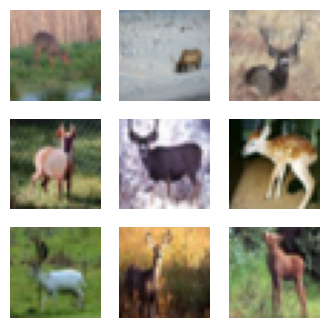

In [4]:
# #Test only grabbing images of one type

#Load the CIFAR10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#Concatenate X_train and X_test for more data
X_train = np.concatenate((X_train,X_test))
y_train = np.concatenate((y_train,y_test))
#Only use index 0, AKA Airplanes
index = np.where(y_train.reshape(-1) == 4)
X_train = X_train[index]
y_train = y_train[index]

#Testing to make sure it's just airplanes
fig,axs = plt.subplots(3,3,figsize=(4,4),sharey=True,sharex=True)
cnt=0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X_train[-9:][cnt,:,:])
        axs[i, j].axis('off')
        cnt+=1

image shape (32, 32, 3), min val -0.9686274528503418, max val 0.8352941274642944
Epoch 0
Time for epoch:  26.866827964782715
loss_d=0.39654, loss_g=1.14933
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

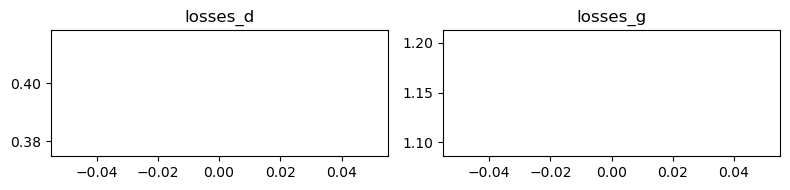

Epoch 1
Time for epoch:  23.773548364639282
Epoch 2
Time for epoch:  24.58416247367859
Epoch 3
Time for epoch:  23.88804841041565
Epoch 4
Time for epoch:  23.524416208267212
Epoch 5
Time for epoch:  24.477617979049683
loss_d=0.51713, loss_g=1.24315
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


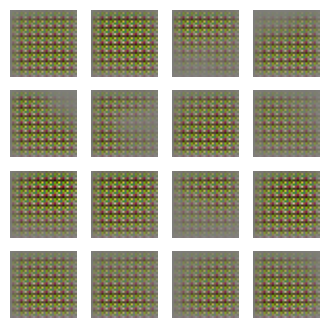

<Figure size 1600x1600 with 0 Axes>

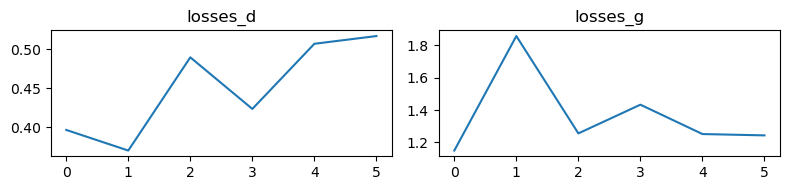

Epoch 6
Time for epoch:  24.02846670150757
Epoch 7
Time for epoch:  23.918004989624023
Epoch 8
Time for epoch:  24.78822088241577
Epoch 9
Time for epoch:  25.18896508216858
Epoch 10
Time for epoch:  24.36102843284607
loss_d=0.42169, loss_g=1.29688
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


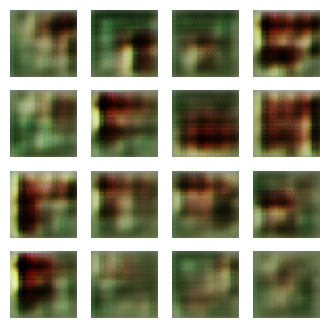

<Figure size 1600x1600 with 0 Axes>

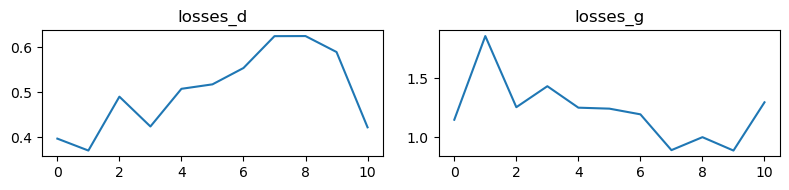

Epoch 11
Time for epoch:  23.90619206428528
Epoch 12
Time for epoch:  24.145389080047607
Epoch 13
Time for epoch:  22.812099933624268
Epoch 14
Time for epoch:  22.500945806503296
Epoch 15
Time for epoch:  24.180959701538086
loss_d=0.72263, loss_g=0.98407
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


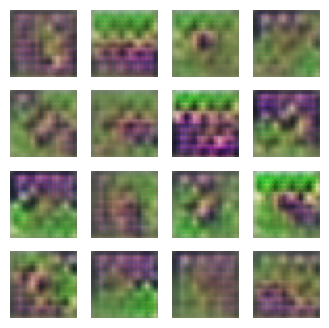

<Figure size 1600x1600 with 0 Axes>

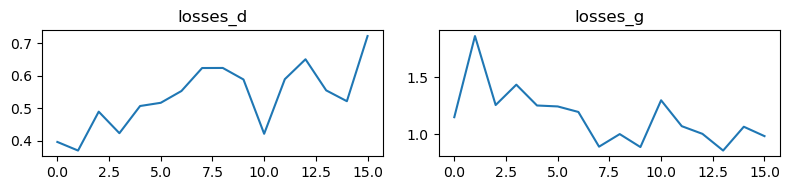

Epoch 16
Time for epoch:  23.800288677215576
Epoch 17
Time for epoch:  24.28255343437195
Epoch 18
Time for epoch:  25.120739221572876
Epoch 19
Time for epoch:  24.543154001235962
Epoch 20
Time for epoch:  24.046828031539917
loss_d=0.68482, loss_g=0.86179
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


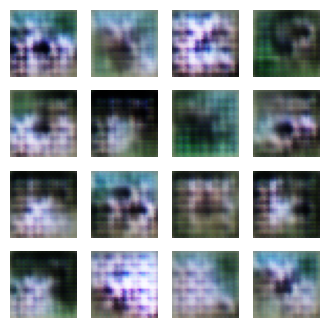

<Figure size 1600x1600 with 0 Axes>

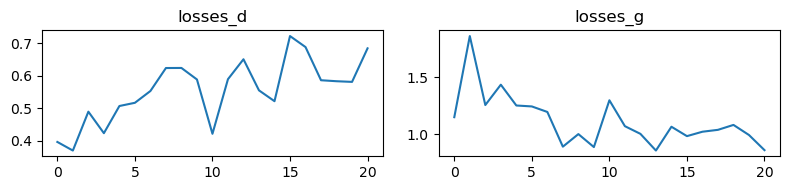

Epoch 21
Time for epoch:  24.400484800338745
Epoch 22
Time for epoch:  25.17090916633606
Epoch 23
Time for epoch:  23.340280294418335
Epoch 24
Time for epoch:  22.78122568130493
Epoch 25
Time for epoch:  24.07418441772461
loss_d=0.69707, loss_g=0.84742
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


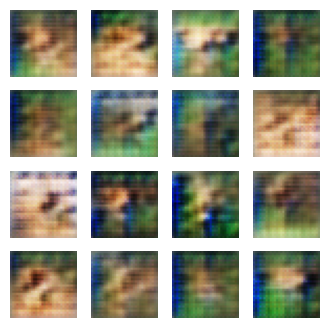

<Figure size 1600x1600 with 0 Axes>

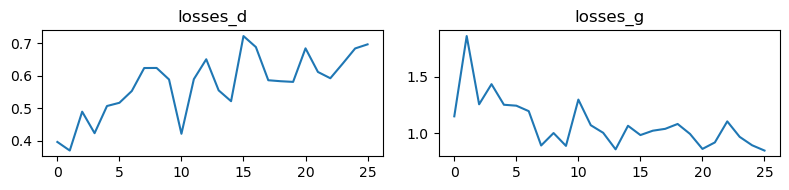

Epoch 26
Time for epoch:  23.664392232894897
Epoch 27
Time for epoch:  23.063853979110718
Epoch 28
Time for epoch:  23.42943000793457
Epoch 29
Time for epoch:  24.276408433914185
Epoch 30
Time for epoch:  25.96320152282715
loss_d=0.67037, loss_g=0.92091
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


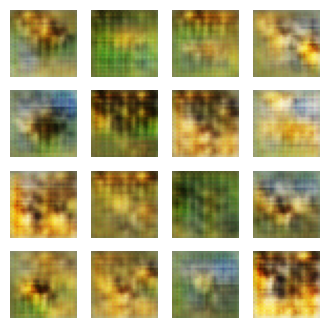

<Figure size 1600x1600 with 0 Axes>

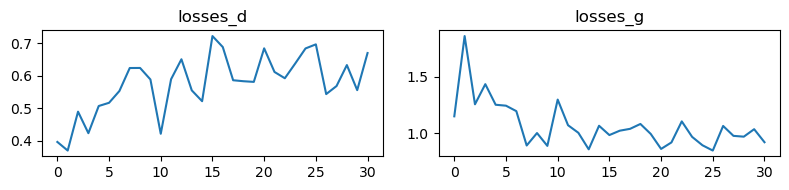

Epoch 31
Time for epoch:  26.178231716156006
Epoch 32
Time for epoch:  24.68639039993286
Epoch 33
Time for epoch:  24.382261991500854
Epoch 34
Time for epoch:  23.846665620803833
Epoch 35
Time for epoch:  23.426803827285767
loss_d=0.58944, loss_g=1.01831
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


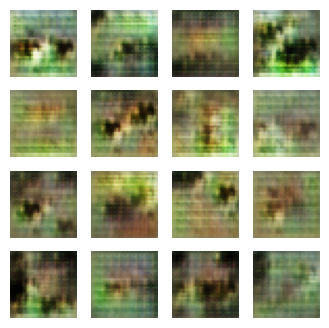

<Figure size 1600x1600 with 0 Axes>

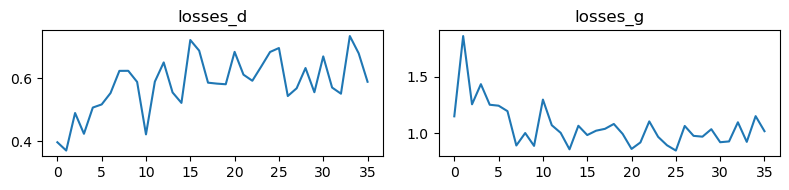

Epoch 36
Time for epoch:  23.561707019805908
Epoch 37
Time for epoch:  23.462159395217896
Epoch 38
Time for epoch:  23.387160301208496
Epoch 39
Time for epoch:  23.844902276992798
Epoch 40
Time for epoch:  23.250565767288208
loss_d=0.62505, loss_g=1.18465
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


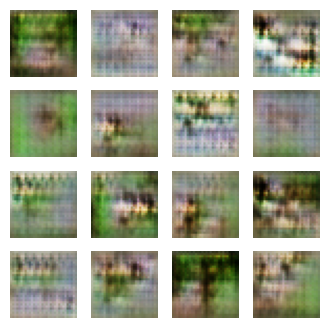

<Figure size 1600x1600 with 0 Axes>

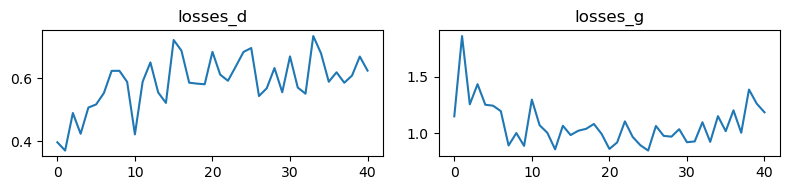

Epoch 41
Time for epoch:  23.194042444229126
Epoch 42
Time for epoch:  23.20329713821411
Epoch 43
Time for epoch:  23.312849044799805
Epoch 44
Time for epoch:  23.994285106658936
Epoch 45
Time for epoch:  23.23056387901306
loss_d=0.54103, loss_g=1.12457
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


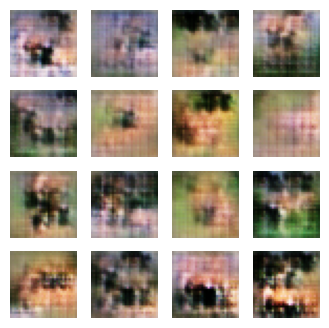

<Figure size 1600x1600 with 0 Axes>

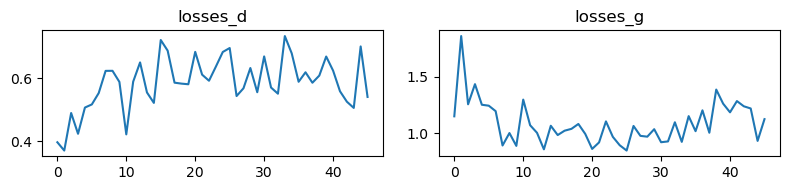

Epoch 46
Time for epoch:  23.139212608337402
Epoch 47
Time for epoch:  23.078777551651
Epoch 48
Time for epoch:  23.26871395111084
Epoch 49
Time for epoch:  23.504720211029053
Epoch 50
Time for epoch:  23.103453159332275
loss_d=0.58697, loss_g=1.20151
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


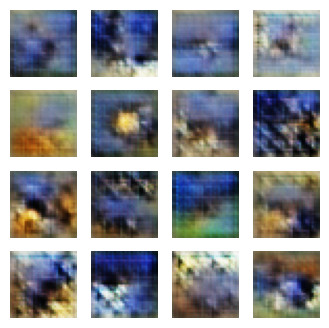

<Figure size 1600x1600 with 0 Axes>

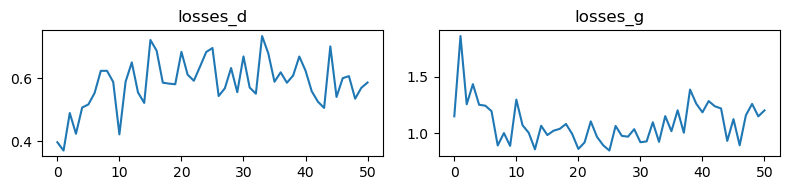

Epoch 51
Time for epoch:  23.34446406364441
Epoch 52
Time for epoch:  23.471817016601562
Epoch 53
Time for epoch:  23.356746673583984
Epoch 54
Time for epoch:  23.267916202545166
Epoch 55
Time for epoch:  23.50462031364441
loss_d=0.61016, loss_g=1.23032
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


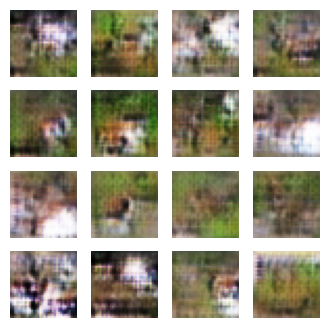

<Figure size 1600x1600 with 0 Axes>

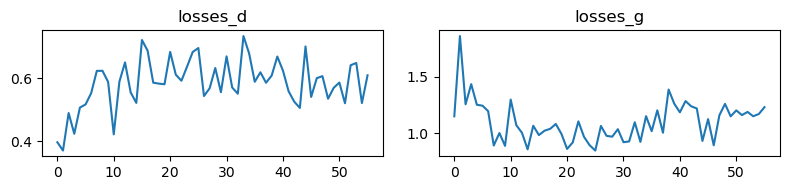

Epoch 56
Time for epoch:  23.129470825195312
Epoch 57
Time for epoch:  23.606196880340576
Epoch 58
Time for epoch:  23.275640964508057
Epoch 59
Time for epoch:  23.14639639854431
Epoch 60
Time for epoch:  23.797704219818115
loss_d=0.59023, loss_g=1.21881
2/2 [==============================] - 0s 7ms/step
	Plotting images and losses


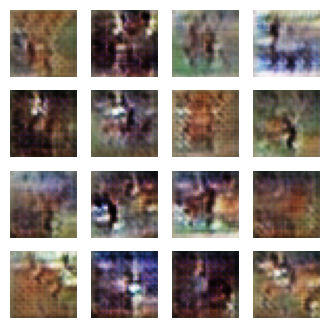

<Figure size 1600x1600 with 0 Axes>

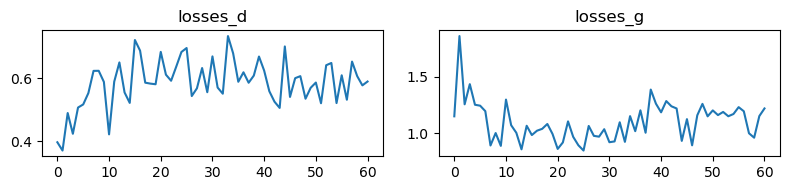

Epoch 61
Time for epoch:  29.0200834274292
Epoch 62
Time for epoch:  27.456117868423462
Epoch 63
Time for epoch:  27.16495633125305
Epoch 64
Time for epoch:  27.056645393371582
Epoch 65
Time for epoch:  27.020166635513306
loss_d=0.54883, loss_g=0.96649
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


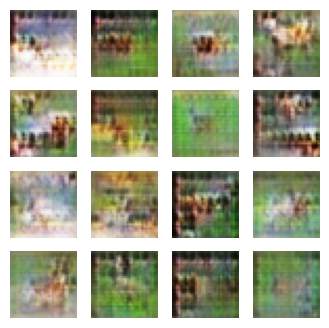

<Figure size 1600x1600 with 0 Axes>

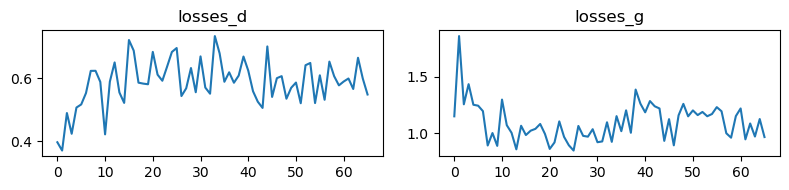

Epoch 66
Time for epoch:  27.566210508346558
Epoch 67
Time for epoch:  27.200029134750366
Epoch 68
Time for epoch:  27.1990864276886
Epoch 69
Time for epoch:  27.113818883895874
Epoch 70
Time for epoch:  27.14596199989319
loss_d=0.53568, loss_g=1.30987
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


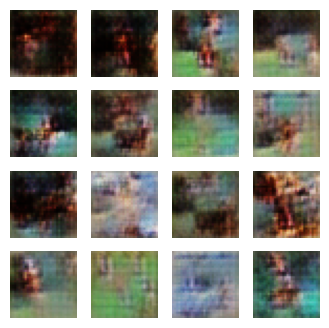

<Figure size 1600x1600 with 0 Axes>

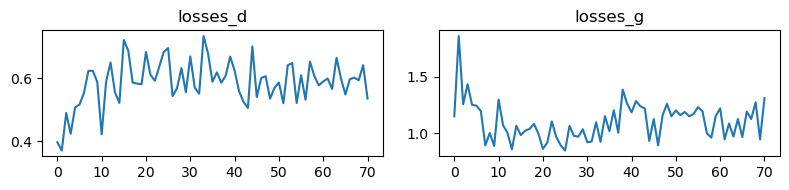

Epoch 71
Time for epoch:  28.106392860412598
Epoch 72
Time for epoch:  27.20691680908203
Epoch 73
Time for epoch:  27.389046907424927
Epoch 74
Time for epoch:  28.0150249004364
Epoch 75
Time for epoch:  27.524126768112183
loss_d=0.51341, loss_g=1.08614
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


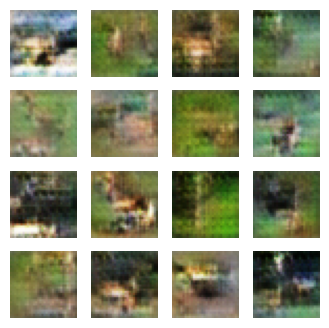

<Figure size 1600x1600 with 0 Axes>

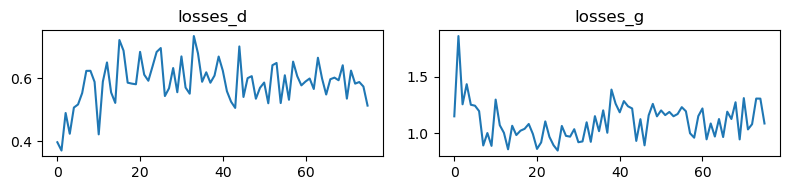

Epoch 76
Time for epoch:  27.388386964797974
Epoch 77
Time for epoch:  27.245834827423096
Epoch 78
Time for epoch:  27.369967699050903
Epoch 79
Time for epoch:  27.085152864456177
Epoch 80
Time for epoch:  26.285985946655273
loss_d=0.54225, loss_g=1.40959
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


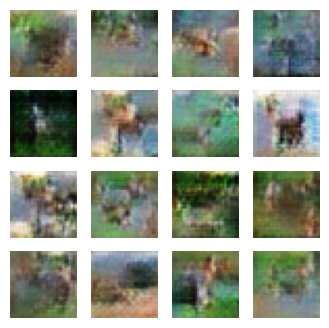

<Figure size 1600x1600 with 0 Axes>

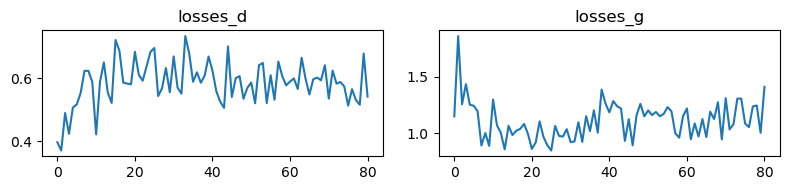

Epoch 81
Time for epoch:  26.956227779388428
Epoch 82
Time for epoch:  27.15677237510681
Epoch 83
Time for epoch:  26.656811475753784
Epoch 84
Time for epoch:  26.743340730667114
Epoch 85
Time for epoch:  26.651817798614502
loss_d=0.54860, loss_g=1.14769
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


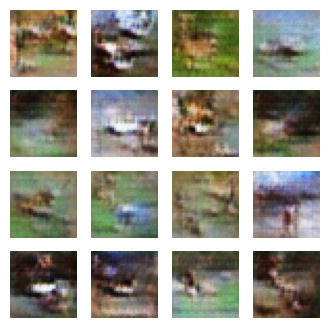

<Figure size 1600x1600 with 0 Axes>

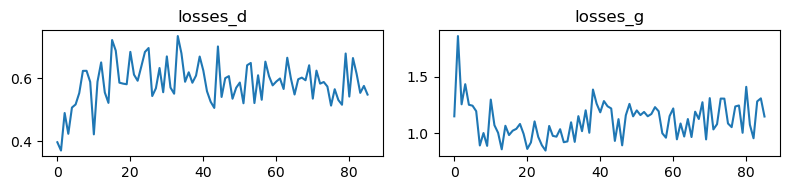

Epoch 86
Time for epoch:  26.25917673110962
Epoch 87
Time for epoch:  26.341676712036133
Epoch 88
Time for epoch:  26.43399214744568
Epoch 89
Time for epoch:  26.45973777770996
Epoch 90
Time for epoch:  26.328308820724487
loss_d=0.64042, loss_g=1.04841
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


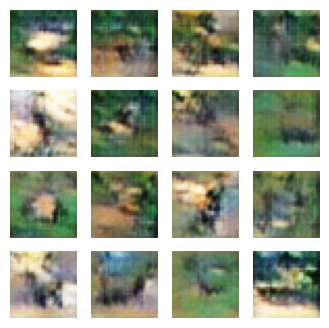

<Figure size 1600x1600 with 0 Axes>

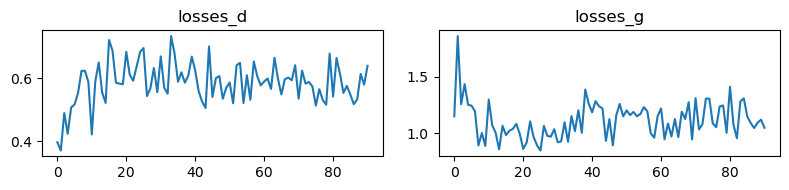

Epoch 91
Time for epoch:  26.496036767959595
Epoch 92
Time for epoch:  26.47192645072937
Epoch 93
Time for epoch:  26.464094638824463
Epoch 94
Time for epoch:  31.67595362663269
Epoch 95
Time for epoch:  27.841954469680786
loss_d=0.57707, loss_g=1.17077
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


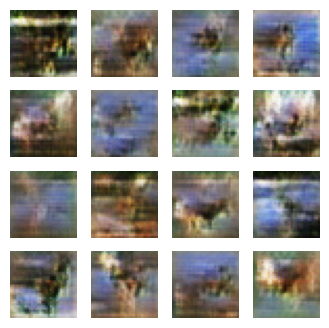

<Figure size 1600x1600 with 0 Axes>

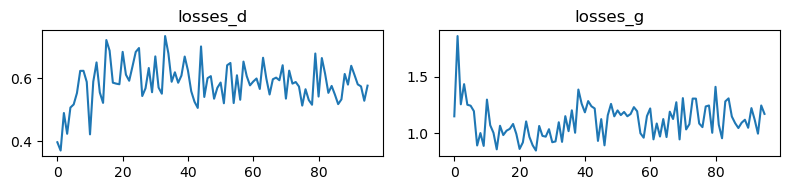

Epoch 96
Time for epoch:  26.13689684867859
Epoch 97
Time for epoch:  26.385850191116333
Epoch 98
Time for epoch:  26.965283155441284
Epoch 99
Time for epoch:  26.71032428741455
Epoch 100
Time for epoch:  25.615800619125366
loss_d=0.63403, loss_g=1.16708
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


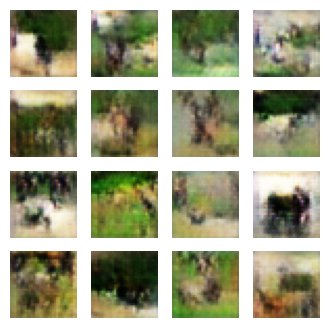

<Figure size 1600x1600 with 0 Axes>

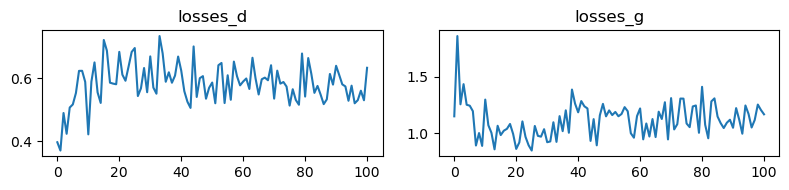

Epoch 101
Time for epoch:  24.534727811813354
Epoch 102
Time for epoch:  23.40406560897827
Epoch 103
Time for epoch:  23.002913236618042
Epoch 104
Time for epoch:  23.005342960357666
Epoch 105
Time for epoch:  25.698745489120483
loss_d=0.66624, loss_g=1.17154
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


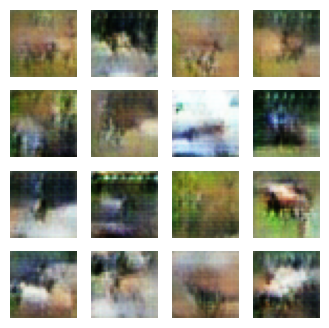

<Figure size 1600x1600 with 0 Axes>

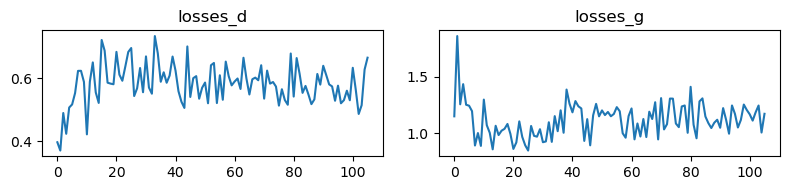

Epoch 106
Time for epoch:  26.159623622894287
Epoch 107
Time for epoch:  26.18995213508606
Epoch 108
Time for epoch:  26.256327152252197
Epoch 109
Time for epoch:  26.210973501205444
Epoch 110
Time for epoch:  25.948092937469482
loss_d=0.59556, loss_g=1.08293
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


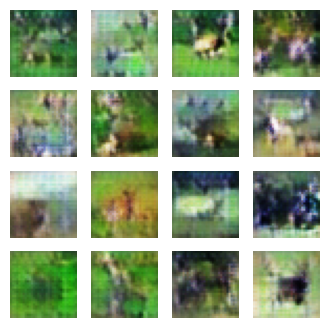

<Figure size 1600x1600 with 0 Axes>

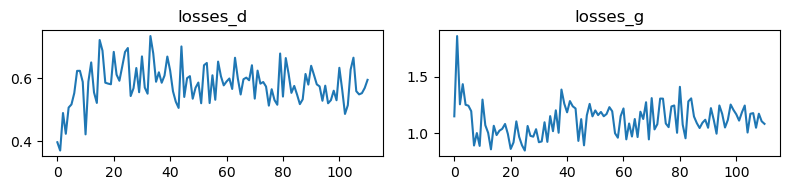

Epoch 111
Time for epoch:  26.85772204399109
Epoch 112
Time for epoch:  26.79027271270752
Epoch 113
Time for epoch:  26.683773279190063
Epoch 114
Time for epoch:  24.7913498878479
Epoch 115
Time for epoch:  24.82551598548889
loss_d=0.60198, loss_g=1.13147
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


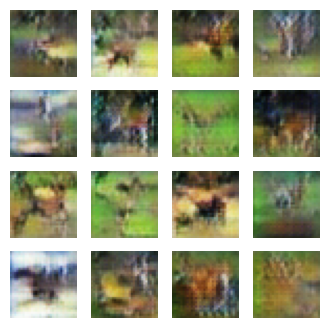

<Figure size 1600x1600 with 0 Axes>

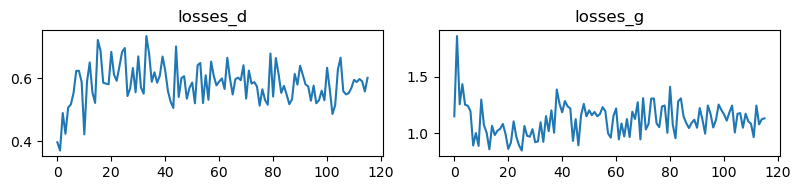

Epoch 116
Time for epoch:  24.25088930130005
Epoch 117
Time for epoch:  24.64625096321106
Epoch 118
Time for epoch:  24.232917070388794
Epoch 119
Time for epoch:  24.254997968673706
Epoch 120
Time for epoch:  23.963857412338257
loss_d=0.56798, loss_g=0.94913
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


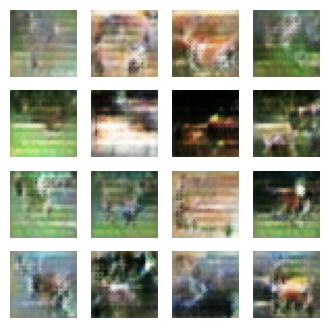

<Figure size 1600x1600 with 0 Axes>

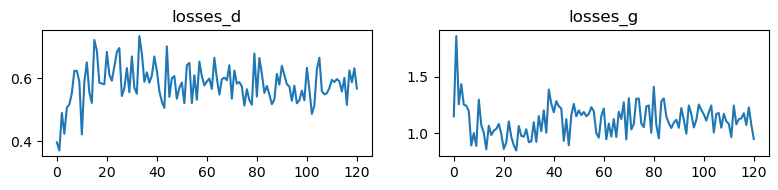

Epoch 121
Time for epoch:  24.346548318862915
Epoch 122
Time for epoch:  26.963390350341797
Epoch 123
Time for epoch:  23.672204732894897
Epoch 124
Time for epoch:  23.290127754211426
Epoch 125
Time for epoch:  23.125704288482666
loss_d=0.52312, loss_g=1.10175
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


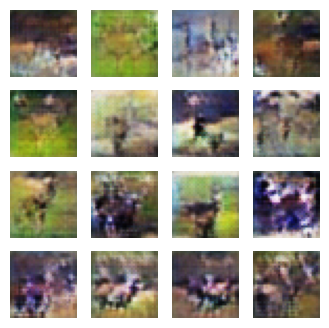

<Figure size 1600x1600 with 0 Axes>

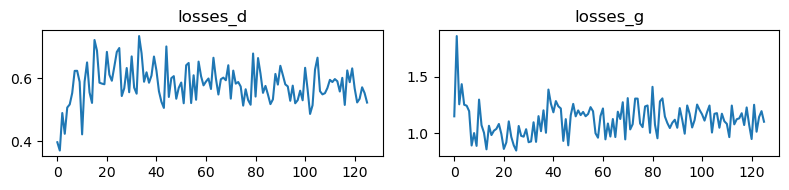

Epoch 126
Time for epoch:  23.159292936325073
Epoch 127
Time for epoch:  23.165002584457397
Epoch 128
Time for epoch:  25.117643356323242
Epoch 129
Time for epoch:  26.90039825439453
Epoch 130
Time for epoch:  26.434425830841064
loss_d=0.58875, loss_g=1.01651
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


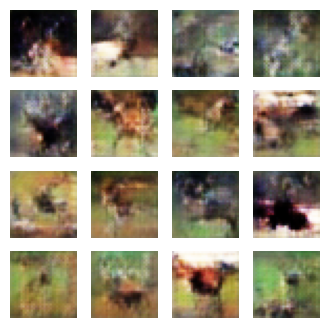

<Figure size 1600x1600 with 0 Axes>

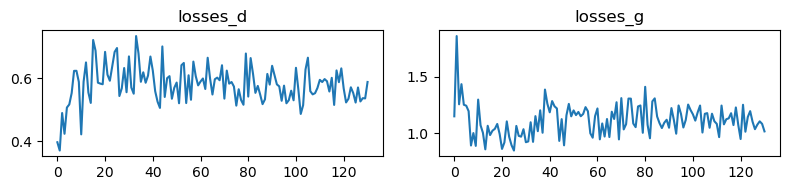

Epoch 131
Time for epoch:  26.25115394592285
Epoch 132
Time for epoch:  26.557159185409546
Epoch 133
Time for epoch:  26.272984504699707
Epoch 134
Time for epoch:  26.61543297767639
Epoch 135
Time for epoch:  25.990426063537598
loss_d=0.55543, loss_g=1.10792
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


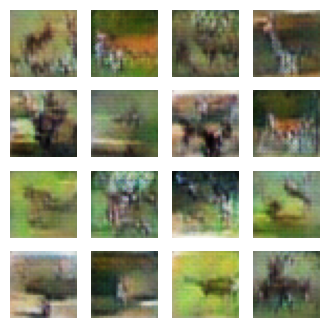

<Figure size 1600x1600 with 0 Axes>

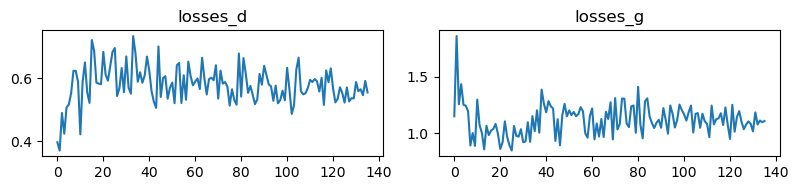

Epoch 136
Time for epoch:  26.191943883895874
Epoch 137
Time for epoch:  26.224868059158325
Epoch 138
Time for epoch:  26.537188291549683
Epoch 139
Time for epoch:  26.676878690719604
Epoch 140
Time for epoch:  26.33588480949402
loss_d=0.59776, loss_g=1.06857
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


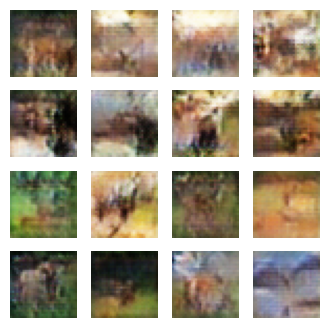

<Figure size 1600x1600 with 0 Axes>

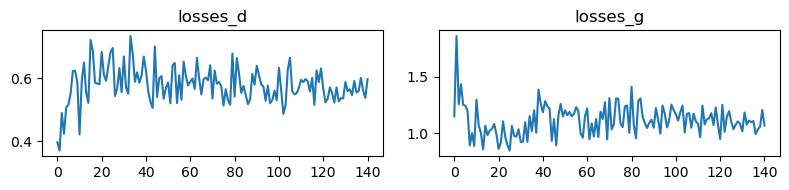

Epoch 141
Time for epoch:  26.62333583831787
Epoch 142
Time for epoch:  26.773853540420532
Epoch 143
Time for epoch:  26.56203818321228
Epoch 144
Time for epoch:  26.05397343635559
Epoch 145
Time for epoch:  27.041856288909912
loss_d=0.62303, loss_g=1.04852
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


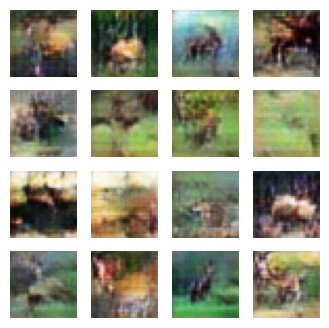

<Figure size 1600x1600 with 0 Axes>

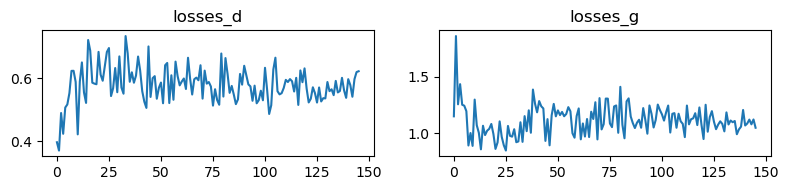

Epoch 146
Time for epoch:  26.493922233581543
Epoch 147
Time for epoch:  25.001014709472656
Epoch 148
Time for epoch:  23.261487245559692
Epoch 149
Time for epoch:  23.60282254219055


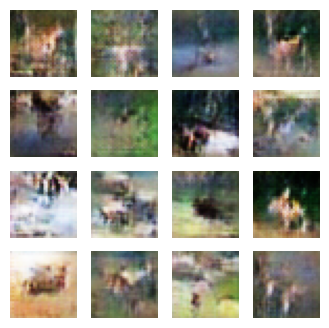

In [5]:
#Training Function
def train(z_dim=100, epochs=150,
          batch_size=16, epoch_per_checkpoint=5, n_checkpoint_images=36):

    #Load the CIFAR10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #Concatenate X_train and X_test for more data
    X_train = np.concatenate((X_train,X_test))
    y_train = np.concatenate((y_train,y_test))
    #Only grab deer
    index = np.where(y_train.reshape(-1) == 4)
    X_train = X_train[index]
    y_train = y_train[index]
    #Convert data to floats, Scale data to -1, 1
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = X_train/127.5 - 1.0
    
    
    #Get image shapes and values for reference
    image_shape = X_train[0].shape
    print("image shape {}, min val {}, max val {}".format(image_shape, X_train[0].min(), X_train[0].max()))
    #Plot real images for reference
    plot_images(X_train[:n_checkpoint_images], "real_images.png")


    #Get labels for computing the losses
    labels_real = np.ones(shape=(batch_size, 1)) 
    labels_fake = np.zeros(shape=(batch_size, 1))
    #Smooth labels to prevent mode collapse
    labels_real = smooth_positive_labels(labels_real)
    labels_fake = smooth_negative_labels(labels_fake)

    losses_d, losses_g = [], []

    
    # training loop
    for e in range(epochs):
        start = time.time()
        print("Epoch {}".format(e))
        for i in range(len(X_train) // batch_size):

            # update Discriminator weights
            D.trainable = True

            # Get real samples, train discriminator on them
            real_images = X_train[i*batch_size: (i+1)*batch_size]
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 real_images[j] = noisy(real_images[j])
            loss_d_real = D.train_on_batch(x=real_images, y=labels_real)[0]

            # Make fake samples, train discriminator on them
            z = generate_latent_points(z_dim, batch_size)
            fake_images = G.predict_on_batch(z)
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 fake_images[j] = noisy(fake_images[j])
            loss_d_fake = D.train_on_batch(x=fake_images, y=labels_fake)[0]

            # Compute Discriminator's loss
            loss_d = 0.5 * (loss_d_real + loss_d_fake)

#             # Train the generator while the discriminator is static
#             D.trainable = False
#             loss_g1 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
#             # Update Generator again (train it twice as much as the Discriminator)
#             loss_g2 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
            
#             # Compute Generator's loss
#             loss_g = 0.5 * (loss_g1 + loss_g2)
            # Train the generator while the discriminator is static
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=labels_real)[0]


        #Keep track of losses for plotting
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        
        end = time.time()
        print("Time for epoch:  " + str(end-start))

        
        #Plot losses and generated images every X epochs
        if (e % epoch_per_checkpoint) == 0:
            print("loss_d={:.5f}, loss_g={:.5f}".format(loss_d, loss_g))
            
            # fix a z vector for training evaluation
            z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
            
            fake_images = G.predict(z_fixed)
            print("\tPlotting images and losses")
            plot_images(fake_images, "fake_images_deer_e{}.png".format(e))
            plot_losses(losses_d, losses_g, "losses.png")
            
            #Show Images
            fake_images = (fake_images + 1) * 127.5
            fake_images = np.rint(fake_images)
            fake_images = fake_images.astype(int)

            fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
            cnt=0
            for k in range(4):
                for l in range(4):
                    axs[k, l].imshow(fake_images[cnt,:,:])
                    axs[k, l].axis('off')
                    cnt+=1

            #Save Model every 10 epochs
#             if (e % 10) == 0 and e != 0:
#                 print('Saving Models')
#                 D.save('./DiscriminatorModel')
#                 D_of_G.save('./CombinedModel')
            
            
train()

4/4 [==============================] - 0s 10ms/step


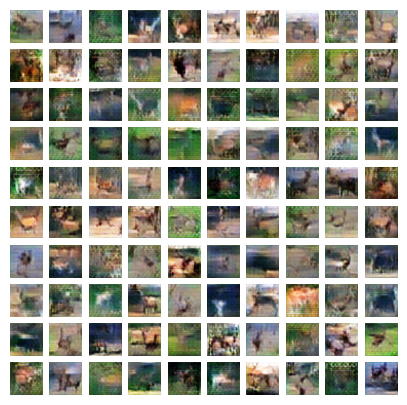

In [6]:
# #Print example images 
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(5,5),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1

4/4 [==============================] - 0s 9ms/step


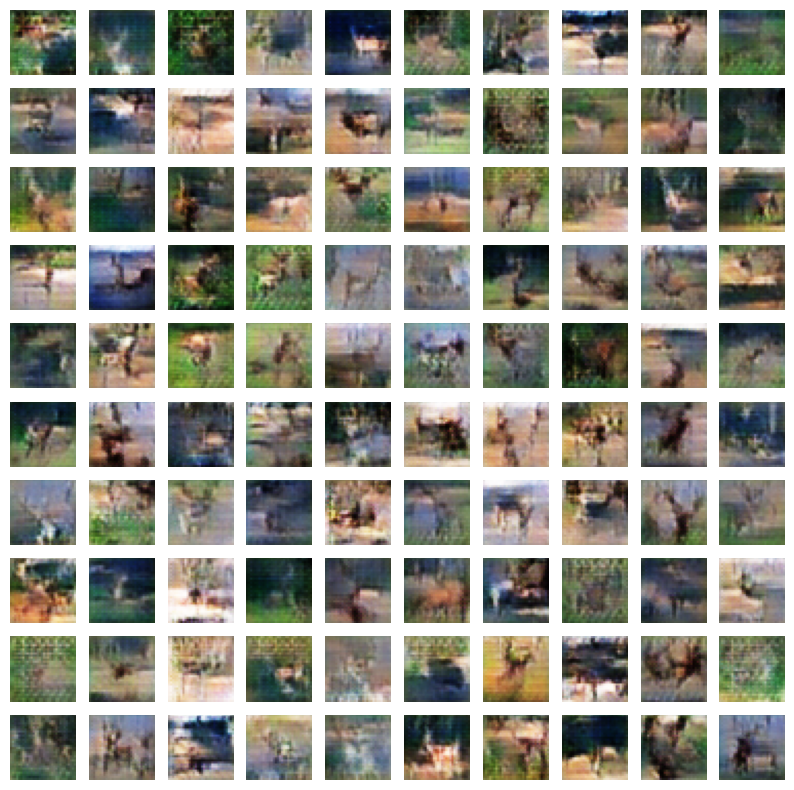

In [8]:
# #Print example images 
#Default Sets, 250 epochs
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(10,10),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1